In [1]:
import jax
import jax.numpy as jnp
from matplotlib import pyplot as plt

import cryojax.simulator as cxs
from cryojax.io import read_atoms_from_pdb


atom_positions, atom_identities, b_factors = read_atoms_from_pdb(
    "./data/5w0s.pdb", get_b_factors=True
)
atom_potential = cxs.PengAtomicPotential(atom_positions, atom_identities, b_factors)

instrument_config = cxs.InstrumentConfig(
    shape=(109, 110),
    pixel_size=2.0,
    voltage_in_kilovolts=200.0,
)

real_voxel_grid = atom_potential.as_real_voxel_grid(
    (110, 110, 110), instrument_config.pixel_size
)
voxel_potential = cxs.FourierVoxelGridPotential.from_real_voxel_grid(
    real_voxel_grid, instrument_config.pixel_size, pad_scale=1.5
)

In [2]:
import cryojax.experimental as cxe


pose = cxs.EulerAnglePose(
    offset_x_in_angstroms=6.0,
    offset_y_in_angstroms=-7.0,
    view_theta=90.0,
    view_psi=20.0,
    view_phi=0.0,
)
structural_ensemble = cxs.SingleStructureEnsemble(voxel_potential, pose)

wtf = cxe.WaveTransferFunction(
    defocus_in_angstroms=10000.0,
    astigmatism_in_angstroms=-100.0,
    astigmatism_angle=10.0,
    amplitude_contrast_ratio=0.1,
)
ctf = cxs.ContrastTransferFunction(
    defocus_in_angstroms=wtf.defocus_in_angstroms,
    astigmatism_in_angstroms=wtf.astigmatism_in_angstroms,
    astigmatism_angle=wtf.astigmatism_angle,
    amplitude_contrast_ratio=wtf.amplitude_contrast_ratio,
)

In [3]:
from cryojax.image import operators as op


strength = 0.05 * real_voxel_grid.sum(axis=0).max() * voxel_potential.voxel_size
solvent = cxs.GaussianIce(
    variance_function=op.Lorenzian(
        amplitude=strength**2, length_scale=2.0 * voxel_potential.voxel_size
    )
)

scattering_theory_wo_ewald = cxs.WeakPhaseScatteringTheory(
    structural_ensemble,
    cxs.FourierSliceExtraction(),
    cxs.ContrastTransferTheory(ctf),
    solvent,
)
scattering_theory_w_ewald = cxs.WeakPhaseScatteringTheory(
    structural_ensemble,
    cxe.EwaldSphereExtraction(),
    cxs.ContrastTransferTheory(ctf),
    solvent,
)

In [4]:
imaging_pipeline_wo_ewald = cxs.ContrastImagingPipeline(
    instrument_config, scattering_theory_wo_ewald
)
imaging_pipeline_w_ewald = cxs.ContrastImagingPipeline(
    instrument_config, scattering_theory_w_ewald
)

key = jax.random.key(0)
im_wo_ewald, im_w_ewald = (
    imaging_pipeline_wo_ewald.render(key),
    imaging_pipeline_w_ewald.render(key),
)

(109, 55)


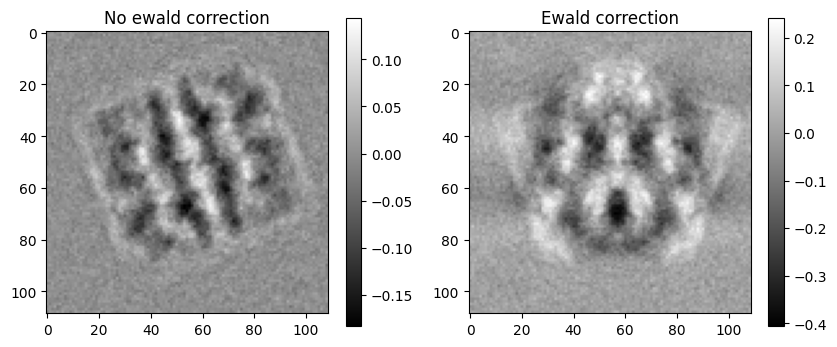

In [5]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4))
m1 = axes[0].imshow(im_wo_ewald, cmap="gray")
m2 = axes[1].imshow(im_w_ewald, cmap="gray")
axes[0].set(title="No ewald correction")
axes[1].set(title="Ewald correction")
fig.colorbar(m1)
fig.colorbar(m2)

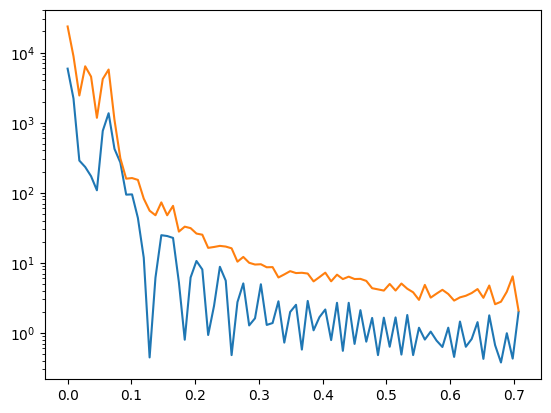

In [6]:
from cryojax.image import compute_radially_averaged_powerspectrum, rfftn


radial_frequency_grid = jnp.linalg.norm(
    instrument_config.frequency_grid_in_pixels, axis=-1
)
spectrum_wo_ewald, bins = compute_radially_averaged_powerspectrum(
    rfftn(im_wo_ewald), radial_frequency_grid
)
spectrum_w_ewald, bins = compute_radially_averaged_powerspectrum(
    rfftn(im_w_ewald), radial_frequency_grid
)

plt.plot(bins, spectrum_wo_ewald, label="No ewald")
plt.plot(bins, spectrum_w_ewald, label="Ewald")
plt.yscale("log")